
=== VERİ BAŞI ===
        Date  CoffeeAmount_ml   Bedtime WakeupTime  SleepQuality  EnergyLevel  \
0 2025-10-10            330.0  22:00:00   09:30:00           4.0          3.0   
1 2025-10-11            250.0  23:30:00   11:30:00           3.0          2.0   
2 2025-10-12            330.0  00:00:00   12:00:00           2.0          2.0   
3 2025-10-13            400.0  23:00:00   10:15:00           5.0          4.0   
4 2025-10-14              0.0  22:00:00   09:30:00           3.0          4.0   

   ExamDay  
0        0  
1        0  
2        0  
3        0  
4        0  

Weather API istekleri yapılıyor...

Weather sütunu eklendi!

=== Eksik Veri Kontrolü ===
Date                      0
CoffeeAmount_ml          20
Bedtime                  20
WakeupTime               20
SleepQuality             20
EnergyLevel              20
ExamDay                   0
Weather_Precipitation     0
SleepDuration_hr         20
Weekday                   0
dtype: int64


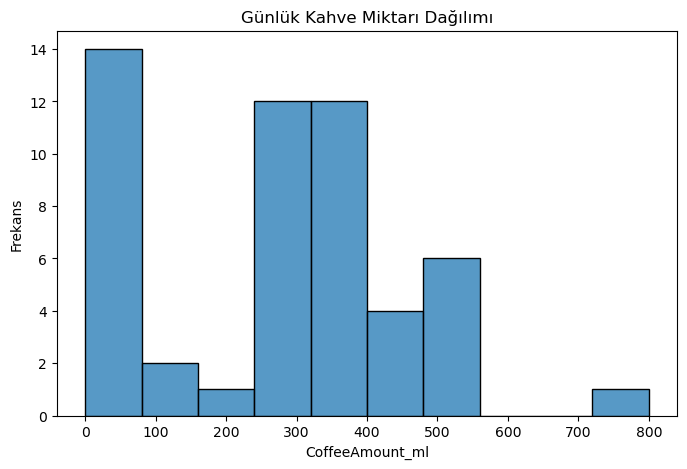

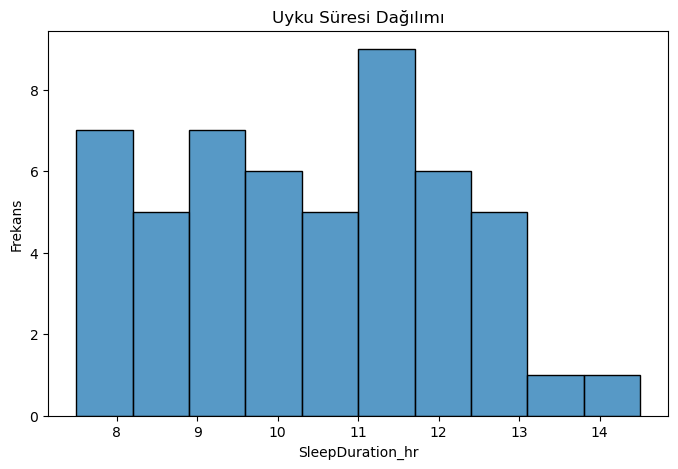

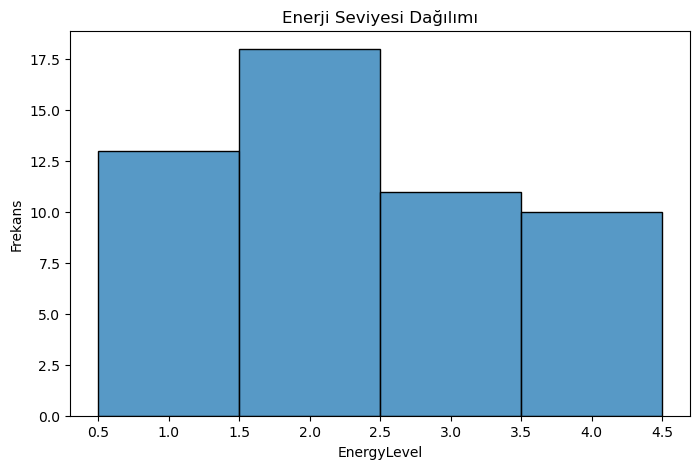

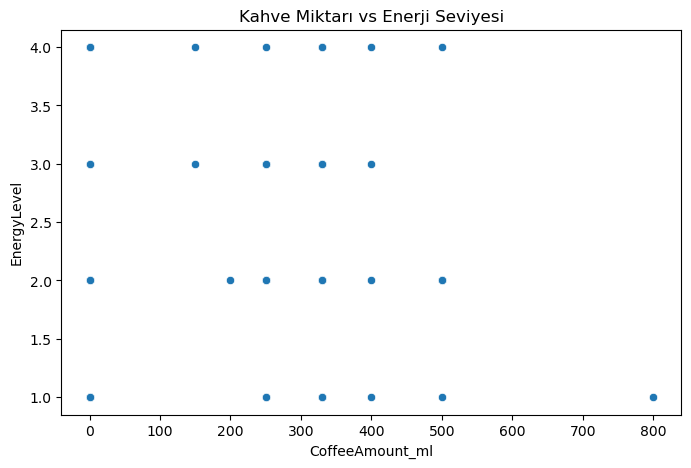

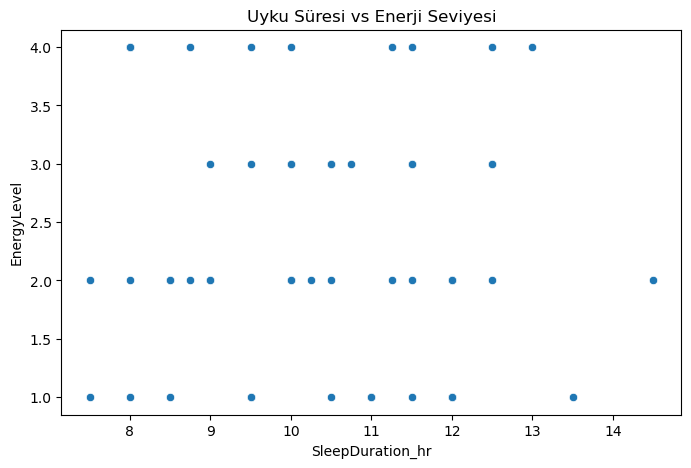


=== Korelasyonlar ===


ValueError: array must not contain infs or NaNs

In [1]:
# ============================================
# Coffee-Sleep Data Analysis for DSA210 Project
# ============================================

import pandas as pd
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# ------------------------------------------------
# 1) Excel dosyasını oku
# ------------------------------------------------

# Excel dosyanın adı (senin dosyan: coffe_consumption.xlsx)
df = pd.read_excel("coffe_consumption.xlsx")

# Tarih sütununu datetime formatına çevir
# (Zaten datetime ise sorun yok, yine de güvenli)
df["Date"] = pd.to_datetime(df["Date"])

print("\n=== VERİ BAŞI ===")
print(df.head())

# ------------------------------------------------
# 2) Weather Condition (Rain) Al - API
# ------------------------------------------------

api_key = "FNMPG7K6B8L9Z5G3TPQA9JSHS"   # ← BURAYA KENDİ VISUAL CROSSING API KEY'İNİ YAZ
city = "Istanbul,Turkey"

precip_list = []

print("\nWeather API istekleri yapılıyor...")

for date in df["Date"]:
    date_api_format = date.strftime("%Y-%m-%d")
    url = (
        f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/"
        f"timeline/{city}/{date_api_format}/{date_api_format}"
        f"?unitGroup=metric&key={api_key}&include=days"
    )

    try:
        resp = requests.get(url)
        data = resp.json()
        precip = data["days"][0].get("precip", 0)
    except Exception as e:
        print(f"Uyarı: {date_api_format} için hava verisi alınamadı: {e}")
        precip = 0

    precip_flag = 1 if precip > 0 else 0
    precip_list.append(precip_flag)

df["Weather_Precipitation"] = precip_list
print("\nWeather sütunu eklendi!")

# ------------------------------------------------
# 3) SleepDuration_hr hesapla
# ------------------------------------------------

def parse_time(t):
    """
    t:
      - NaN olabilir
      - string ('22:00:00' veya '22:00') olabilir
      - datetime.time olabilir
    Hepsini aynı günün datetime'ına çevirir.
    """
    # Eğer boşsa (NaN) direkt None döndür
    if pd.isna(t):
        return None

    # datetime.time ise
    if hasattr(t, "hour") and hasattr(t, "minute") and not isinstance(t, str):
        # keyfi bir tarih ile birleştiriyoruz
        return datetime(2000, 1, 1, t.hour, t.minute, getattr(t, "second", 0))

    # string'e çevir
    s = str(t)

    # önce HH:MM:SS dene
    for fmt in ("%H:%M:%S", "%H:%M"):
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            continue

    # hiçbir formata uymuyorsa None dön
    return None

def calc_sleep_duration(row):
    bedtime = parse_time(row["Bedtime"])
    wakeup = parse_time(row["WakeupTime"])

    # Eğer ikisinden biri boşsa, süre hesaplanamaz → NaN
    if bedtime is None or wakeup is None:
        return None

    # gece yatıp sabah geçen (ör: 23:00 → 07:00)
    if wakeup <= bedtime:
        wakeup += timedelta(days=1)

    duration_hours = (wakeup - bedtime).total_seconds() / 3600
    return duration_hours

df["SleepDuration_hr"] = df.apply(calc_sleep_duration, axis=1)

# ------------------------------------------------
# 4) Weekday sütunu ekle (1 = hafta içi, 0 = hafta sonu)
# ------------------------------------------------

df["Weekday"] = df["Date"].dt.weekday.apply(lambda x: 1 if x < 5 else 0)

# Eğer ExamDay zaten Excel’de varsa kullanıyoruz,
# yoksa istersen buradan da tanımlayabilirsin.
# Örnek (istersen aktif edersin):
# exam_days = ["2025-10-20", "2025-11-05"]
# df["ExamDay"] = df["Date"].dt.strftime("%Y-%m-%d").apply(lambda x: 1 if x in exam_days else 0)

# ------------------------------------------------
# 5) Eksik verileri kontrol et
# ------------------------------------------------

print("\n=== Eksik Veri Kontrolü ===")
print(df.isna().sum())

# ------------------------------------------------
# 6) EDA – Grafikler
# ------------------------------------------------

plt.figure(figsize=(8, 5))
sns.histplot(df["CoffeeAmount_ml"], bins=10)
plt.title("Günlük Kahve Miktarı Dağılımı")
plt.xlabel("CoffeeAmount_ml")
plt.ylabel("Frekans")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df["SleepDuration_hr"], bins=10)
plt.title("Uyku Süresi Dağılımı")
plt.xlabel("SleepDuration_hr")
plt.ylabel("Frekans")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df["EnergyLevel"], bins=5, discrete=True)
plt.title("Enerji Seviyesi Dağılımı")
plt.xlabel("EnergyLevel")
plt.ylabel("Frekans")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="CoffeeAmount_ml", y="EnergyLevel")
plt.title("Kahve Miktarı vs Enerji Seviyesi")
plt.xlabel("CoffeeAmount_ml")
plt.ylabel("EnergyLevel")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="SleepDuration_hr", y="EnergyLevel")
plt.title("Uyku Süresi vs Enerji Seviyesi")
plt.xlabel("SleepDuration_hr")
plt.ylabel("EnergyLevel")
plt.show()

# ------------------------------------------------
# 7) Korelasyon + Hipotez Testi
# ------------------------------------------------

print("\n=== Korelasyonlar ===")
pearson_r, pearson_p = pearsonr(df["CoffeeAmount_ml"], df["EnergyLevel"])
spearman_rho, spearman_p = spearmanr(df["CoffeeAmount_ml"], df["EnergyLevel"])

print(f"Pearson r = {pearson_r:.3f}, p = {pearson_p:.3f}")
print(f"Spearman rho = {spearman_rho:.3f}, p = {spearman_p:.3f}")

print("\n=== Hipotez Testi Sonuçları ===")
if pearson_p < 0.05:
    print("Pearson: H0 reddedildi → Kahve miktarı enerji seviyesini istatistiksel olarak anlamlı şekilde etkiliyor.")
else:
    print("Pearson: H0 reddedilemedi → Kahve miktarının enerji seviyesine etkisi anlamlı değil.")

if spearman_p < 0.05:
    print("Spearman: H0 reddedildi → Kahve miktarı enerji seviyesini istatistiksel olarak anlamlı şekilde etkiliyor.")
else:
    print("Spearman: H0 reddedilemedi → Kahve miktarının enerji seviyesine etkisi anlamlı değil.")

# ------------------------------------------------
# 8) Son veriyi CSV olarak kaydet
# ------------------------------------------------

output_name = "coffee_processed_output.csv"
df.to_csv(output_name, index=False)
print(f"\nYeni CSV oluşturuldu: {output_name}")